# M0 - Dummy Classifier (all features)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.dummy import DummyClassifier


from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from joblib import dump

## Loading Dataset

In [2]:
#INPUT AND OUTPUT LOCATION FOLDER 
location = '/Users/klaaskorteweg/Desktop/Master Thesis/'

train = 'train_data_processed.xlsx'
test = 'test_data_processed.xlsx'

train_df = pd.read_excel(location+train)
test_df = pd.read_excel(location+test)

In [3]:
train_df.drop(columns=['date'], inplace=True)
train_df = train_df.astype(str)

test_df.drop(columns=['date'], inplace=True)
test_df = test_df.astype(str)

print(train_df.columns.tolist())

['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate', 'city', 'attacktype1_txt', 'targtype1_txt', 'gname', 'gsubname', 'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3', 'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday', 'quarter', 'weekend']


## Settings

In [20]:
#NAME AND CLASSIFIER ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
name = "Dummy Classifier"
classifier = DummyClassifier(strategy='stratified')

#TARGET AND FEATURES ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target = 'targtype1_txt'
variables = ['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate',
       'city', 'attacktype1_txt', 'gname', 'gsubname',
       'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3',
       'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday',
       'quarter', 'weekend']

#FEATURE SELECTION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
selector = SelectKBest(score_func=chi2, k='all')

# TIME SERIES CROSS VALIDATION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
k_time_series_splits = 5

## Time Series Cross Validation Split

In [21]:
print("Number of splits:",k_time_series_splits)

tscv = TimeSeriesSplit(n_splits=k_time_series_splits) 

for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print(f"Split {i}")
    print(f"Train: index={train_index}")
    print(f"Validation: index={val_index}")

Number of splits: 5
Split 0
Train: index=[    0     1     2 ... 27178 27179 27180]
Validation: index=[27181 27182 27183 ... 54354 54355 54356]
Split 1
Train: index=[    0     1     2 ... 54354 54355 54356]
Validation: index=[54357 54358 54359 ... 81530 81531 81532]
Split 2
Train: index=[    0     1     2 ... 81530 81531 81532]
Validation: index=[ 81533  81534  81535 ... 108706 108707 108708]
Split 3
Train: index=[     0      1      2 ... 108706 108707 108708]
Validation: index=[108709 108710 108711 ... 135882 135883 135884]
Split 4
Train: index=[     0      1      2 ... 135882 135883 135884]
Validation: index=[135885 135886 135887 ... 163058 163059 163060]


## Encoding & Pipeline

In [22]:
#Seperating variables and target for train and testing set
X_train = train_df[variables]
y_train = train_df[target]
X_test = test_df[variables]
y_test = test_df[target]

#Encoding target variable for train and testing set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Encoding features for pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), variables)
        ],
    remainder='drop'
)

#Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector',selector),
    ('classifier', classifier) 
    ])

## Cross Validation

In [23]:
cv_scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring = 'accuracy')

print("Base Model ({}):".format(name))
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Base Model (Dummy Classifier):
Cross-validation scores: [0.18148366 0.17482337 0.18037975 0.16978216 0.18141007]
Mean CV score: 0.1775758021783927


In [24]:
pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iyear', 'imonth', 'iday',
                                                   'country_txt', 'region_txt',
                                                   'provstate', 'city',
                                                   'attacktype1_txt', 'gname',
                                                   'gsubname', 'weaptype1_txt',
                                                   'weapsubtype1_txt', 'crit1',
                                                   'crit2', 'crit3', 'multiple',
                                                   'suicide', 'individual',
                                                   'INT_MISC', 'weekday',
                                                   'quarter', 'weekend'])])),
                ('selector',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x14afb34c0>)),
                ('classifier', DummyClassifier(strategy='stratified'))])

In [25]:
opt_test_accuracy = pipeline.score(X_test, y_test_encoded)
opt_train_accuracy = pipeline.score(X_train, y_train_encoded)

opt_train_predictions = pipeline.predict(X_train)
opt_test_predictions = pipeline.predict(X_test)

print("Baseline ({}):".format(name))
print("Train accuracy",opt_train_accuracy)
print("Test accuracy",opt_test_accuracy)


Baseline (Dummy Classifier):
Train accuracy 0.18038034845855233
Test accuracy 0.18340047123204378


## Summary

In [26]:
print(name)
print()
print("Time Series Split:")
print('- Number of splits:',k_time_series_splits)
print('- Split Indices:')
split_info = {}
for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    split_info[f"Split {i}"] = {'Train': f"{train_index[0]}-{train_index[-1]}", 'Val': f"{val_index[0]}-{val_index[-1]}"}
print(" ",split_info)
print()

print()
print("Baseline Model:")
print("- TSCV scores:", cv_scores)
print("- Mean TSCV score (best param.):", cv_scores.mean())
print("- Training set accuracy:", opt_train_accuracy)
print("- Testing set accuracy:",opt_test_accuracy)


Dummy Classifier

Time Series Split:
- Number of splits: 5
- Split Indices:
  {'Split 0': {'Train': '0-27180', 'Val': '27181-54356'}, 'Split 1': {'Train': '0-54356', 'Val': '54357-81532'}, 'Split 2': {'Train': '0-81532', 'Val': '81533-108708'}, 'Split 3': {'Train': '0-108708', 'Val': '108709-135884'}, 'Split 4': {'Train': '0-135884', 'Val': '135885-163060'}}


Baseline Model:
- TSCV scores: [0.18148366 0.17482337 0.18037975 0.16978216 0.18141007]
- Mean TSCV score (best param.): 0.1775758021783927
- Training set accuracy: 0.18038034845855233
- Testing set accuracy: 0.18340047123204378


## Error checks

In [27]:
def check_encoding(Y_train, Y_train_encoded, Y_test, Y_test_encoded):
    train_label_map = {val: label for val, label in zip(Y_train_encoded, Y_train)}
    test_label_map = {val: label for val, label in zip(Y_test_encoded, Y_test)}

    for val in set(Y_train_encoded) | set(Y_test_encoded):
        train_label = train_label_map.get(val)
        test_label = test_label_map.get(val)

        if train_label is None:
            print(f"Value {val} is present in test set but not in train set.")
        elif test_label is None:
            print(f"Value {val} is present in train set but not in test set.")
        elif train_label == test_label:
            print(f"Value {val}: {train_label} == {test_label} -- Check")
        else:
            print(f"Value {val}: {train_label} != {test_label} -- NOT EQUAL")


check_encoding(y_train, y_train_encoded, y_test, y_test_encoded)

Value 0: Business == Business -- Check
Value 1: Government (General) == Government (General) -- Check
Value 2: Military == Military -- Check
Value 3: Other == Other -- Check
Value 4: Police == Police -- Check
Value 5: Private Citizens & Property == Private Citizens & Property -- Check


## Error Analysis

[[2447 2402 3034 4333 2750 4766]
 [2422 2378 3047 4591 2764 4908]
 [3042 3073 3929 5543 3374 6087]
 [4366 4472 5619 7886 5011 8680]
 [2671 2884 3393 4986 3110 5525]
 [4718 4774 6180 8775 5504 9617]]


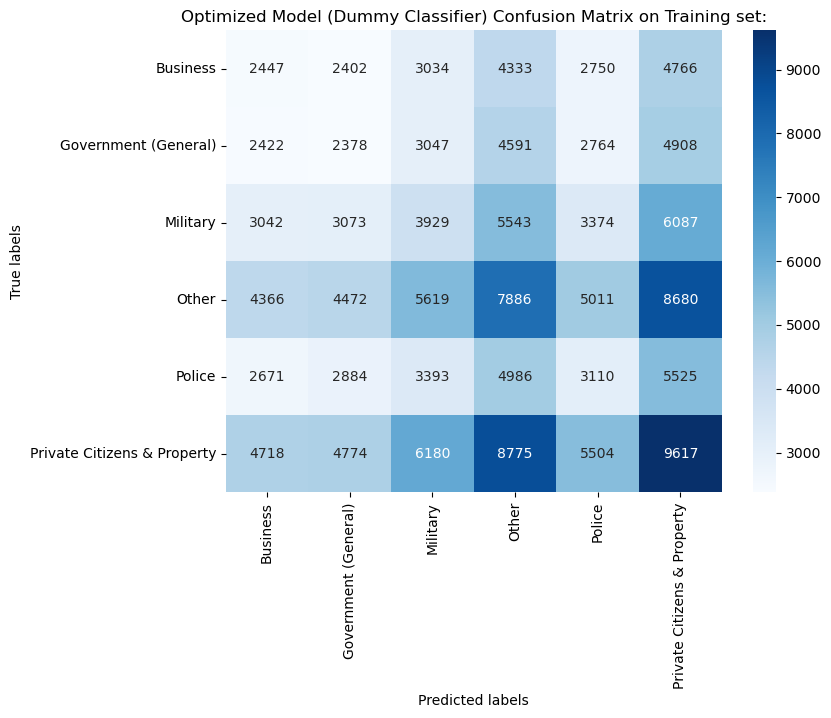

In [28]:

cm = confusion_matrix(y_train_encoded, opt_train_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Training set:".format(name))
plt.show()

[[ 273  307  375  543  331  608]
 [ 433  493  546  806  522  918]
 [1119 1111 1391 2056 1223 2183]
 [ 741  710  880 1197  823 1466]
 [ 775  764  871 1306  803 1480]
 [1507 1516 1883 2781 1658 3072]]


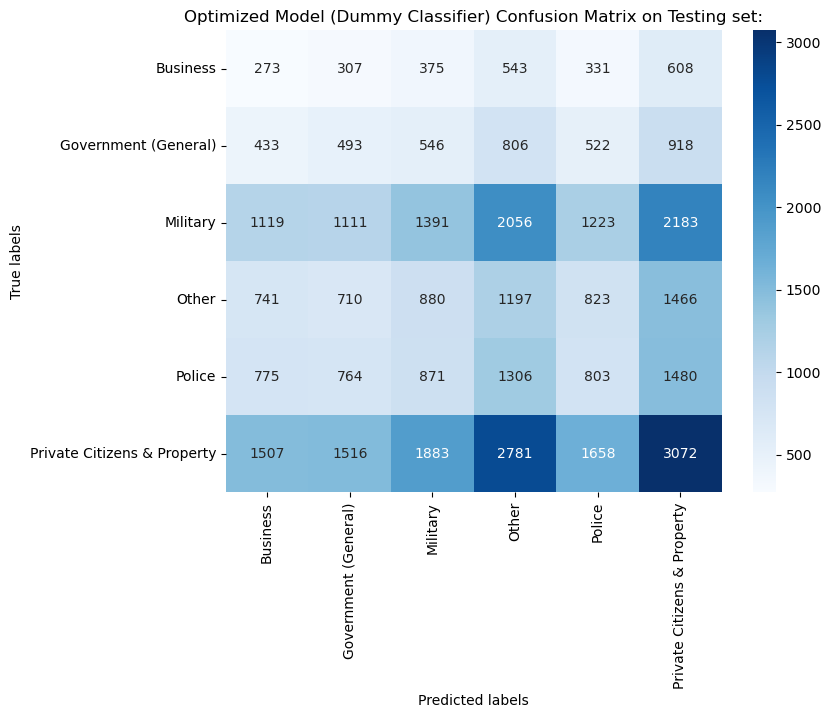

In [29]:

cm = confusion_matrix(y_test_encoded, opt_test_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Testing set:".format(name))
plt.show()

In [30]:
train_report = classification_report(y_train_encoded, opt_train_predictions)
print("Optimized Model ({}) Classification Report on Training set:".format(name))
print(train_report)

test_report = classification_report(y_test_encoded, opt_test_predictions)
print("Optimized Model ({}) Classification Report on Testing set:".format(name))
print(test_report)

Optimized Model (Dummy Classifier) Classification Report on Training set:
              precision    recall  f1-score   support

           0       0.12      0.12      0.12     19732
           1       0.12      0.12      0.12     20110
           2       0.16      0.16      0.16     25048
           3       0.22      0.22      0.22     36034
           4       0.14      0.14      0.14     22569
           5       0.24      0.24      0.24     39568

    accuracy                           0.18    163061
   macro avg       0.17      0.17      0.17    163061
weighted avg       0.18      0.18      0.18    163061

Optimized Model (Dummy Classifier) Classification Report on Testing set:
              precision    recall  f1-score   support

           0       0.06      0.11      0.07      2437
           1       0.10      0.13      0.11      3718
           2       0.23      0.15      0.19      9083
           3       0.14      0.21      0.17      5817
           4       0.15      0.13      

## Save Pipeline

In [31]:
filename = name + '.joblib'

dump(pipeline, filename)

['Dummy Classifier.joblib']